<a href="https://colab.research.google.com/github/a-brice/AI-and-Machine_Learning/blob/main/ml-classification/knn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri Mar 26 21:47:58 2021

@author: brice

prérequis : importer les fichiers 'data.csv', 'preTest.csv' et 'finalTest.csv'
"""

from numpy import sqrt, zeros, trace
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt


In [ ]:

def getdata(file, known_label=True):
    data = []
    df = pd.read_csv(file, header=None)
    
    if known_label:
        df = normaliser(df.loc[: , 0:5]).join(df[6])
    
        for i in range(len(df)):
          *obs, label = list(df.loc[i])
          data.append(Element(label,obs))
    
    else:
        df = normaliser(df.loc[: , 0:5])

        for i in range(len(df)):
          obs = list(df.loc[i])
          data.append(Element('',obs))

    return data     # tableau d'Element 


def normaliser(data):
    mean = np.mean(data)
    std = np.std(data)
    data = (data - mean) / std
    return data
    


In [ ]:

class Element:

    Tdata, Vdata = [],[] # training-data, validation-data
    datalabels = []
    
    def __init__(self, label, obs):
        self.label = label.replace('\n','') if label else '?'
        self.obs = obs 
    
    
    def __str__(self):
        return self.label
    
    def numlabel(lbl):
        return Element.datalabels.index(lbl) if lbl in Element.datalabels else -1
        
    
    
    def distance(self, other):
        assert len(self.obs) == len(other.obs) and isinstance(other, Element) 
        return sqrt(sum([(self.obs[i] - other.obs[i])**2 for i in range(len(self.obs))]))
     
    
    def prediction(self, k):
        ''' 
        On calcul la distance de tout les élements par rapport a l'instance courante 
        que l'on place dans un tableau trié par ordre croissant pour prendre les k-meilleurs 
        distances -> la prédiction sera le label dominant du tableau (qui revient le +)
        '''

        dist = sorted(Element.Tdata,key=self.distance)
        kdist = dist[:k]
        labels = [element.label for element in kdist]
        
        nbmax = max([labels.count(x) for x in labels])
        predictions = [i for i in labels if labels.count(i) == nbmax ]
        nbp = len(predictions)

        prediction = predictions[0] if nbp == 1 else predictions[random.randint(0,nbp-1)]
        return prediction    


In [ ]:

class KNN:
    
    Alldata = []
    
    def __init__(self, d):
        KNN.Alldata = d if d else None
        
        
    def cross_iterateur(pas=50):
        '''
        Permet une cross validation :
        -> retourne a chaque iteration des données de validation et d'entrainement différentes 
        -> toutes les données passent au moins une fois comme données d'entrainement et données de validation
        '''
        for i in range(len(KNN.Alldata)//pas):
            newVdata = KNN.Alldata[i*pas:(i+1)*pas]
            yield newVdata, [elmt for elmt in KNN.Alldata if not elmt in newVdata]
    
    
    def cross_validation(k):
        '''
        Calcul de la matrice de confusion à l'aide de la cross_validation
        Le résultant sera la matrice des moyennes des résultats obtenues en fonction de k 
        '''
        nblabels = len(Element.datalabels)
        mat_conf = zeros((nblabels,nblabels), dtype=int)
        
        for vdata, tdata in KNN.cross_iterateur(pas=len(KNN.Alldata)//5):
            Element.Vdata, Element.Tdata =  vdata, tdata
            
            for data in Element.Vdata:     #test des donnée de validation
                
                l_reel = Element.numlabel(data.label)
                l_predis = Element.numlabel(data.prediction(k))
                
                mat_conf[l_reel, l_predis] += 1
            
        
        df = pd.DataFrame(mat_conf, columns=Element.datalabels, index=Element.datalabels)
        
        erreur = len(KNN.Alldata) - trace(mat_conf)
       
        #Voir la progression
        '''
        print(f'\n\nMatrice de confusion pour k = {k}: \n')
        print(df)
        print('\nfaux positif + vrai négatif = ', erreur)
        '''        
        return {'k':k, 'mat':df, 'err':erreur} # valeur de k, matrice de confusion, nombre d'erreurs
    



In [ ]:

def apprentissage(alldata, range_k=30):

  KNN(alldata)
  Element.datalabels = list( set(x.label for x in alldata) )

  Error = []
    
  best_k = {'k':0, 'mat':[], 'err':1000}
  K = range(1,range_k)  # Initialisation du nombre de k à tester
  for i in K:
        
      n_k = KNN.cross_validation(i)
      Error.append(n_k['err'])
        
      if best_k['err'] > n_k['err']:
          best_k = n_k
            
  
  Element.Tdata = alldata
  # observation 
  plt.plot(K, Error, label='Erreur de prédiction en fonction de k')
  plt.legend()
  plt.show()

  return best_k    
    


In [ ]:

def result_presentation():
    global k, df, T_V_data, deb
    
    print(f'le meilleur k: {k["k"]}', 
          "Matrice de confusion : ", k['mat'], 
          f"Taux d'erreur relevé: {k['err']/len(T_V_data)*100:.2f}%",
          sep='\n\n', end='\n')
    
    print(f"\nEffectué en {(time.time()- deb):.2f} secondes\n", '_'*100,'\n')
    
    #calcul du meilleur k sur les données de test (Final-data)
    print('\n','Tests des données finales :','\n')
    print(df, 'True value :' + str(list(df['Résultats']).count(True)), 
          f"ratio : {(list(df['Résultats']).count(True)/len(df)):.2f}", sep='\n' )
    


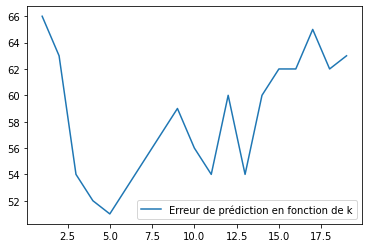

le meilleur k: 5

Matrice de confusion : 

        classE  classD  classB  classC  classA
classE      25       0       0       0       0
classD       0     114       2       3       1
classB       0       1     100       1      10
classC       0       4       0     165       3
classA       0       1      15       8      67

Taux d'erreur relevé: 9.77%

Effectué en 41.30 secondes
 ____________________________________________________________________________________________________ 


 Tests des données finales : 

     Valeurs réelles Valeurs prédites  Résultats
0             classC           classC       True
1             classC           classC       True
2             classC           classC       True
3             classD           classD       True
4             classC           classC       True
...              ...              ...        ...
1079          classC           classC       True
1080          classC           classC       True
1081          classD           classD    

In [ ]:

if __name__ == '__main__':
    
    deb = time.time()
    alldata = getdata('data.csv') + getdata('preTest.csv')
    N = len(alldata)
    alldata = random.sample(alldata, N)
    
    #visualize(alldata)
      
    Fdata, T_V_data = alldata[:int(0.675*N)], alldata[int(0.675*N):] # Final test-data, Training and validation data
    
    
    #calcul du meilleur k sur les données de test (Final-data)
    k = apprentissage(T_V_data, range_k=20)

    # prédiction des données de test 
    Ftest = [(elmt.label, elmt.prediction(k['k']), elmt.label == elmt.prediction(k['k'])) for elmt in Fdata]
    df = pd.DataFrame(Ftest, columns=['Valeurs réelles', 'Valeurs prédites', 'Résultats'])
    result_presentation()

    # prediction des données finales
    finaltest = getdata('finalTest.csv', False)
    prediction = pd.Series([x.prediction(k['k']) for x in finaltest])
    prediction.to_csv('akouvi_brice.txt', index=False, header=None)
    print('','Données finales :', prediction.head(), '...', sep='\n')


In [ ]:

print({i.label:[j.label for j in Element.Tdata].count(i.label) for i in Element.Tdata},
len(Element.Tdata),
len(Fdata)
,sep='\n')

{'classB': 112, 'classD': 120, 'classA': 91, 'classC': 173, 'classE': 26}
522
1084


In [ ]:
e = Element('',[5.2632843390643895,1.1545952942730404,0.7634920471719945,1.4706419139352227,0.4256082149634392,0.04425470382202279])
e.prediction(k['k'])

'classE'